---
title: EDA with Agglomerative Hierarchical Clustering
author: George Whittington
date: today
date-format: long
---

## Imports

In [ ]:
import polars as pl
import polars.selectors as cs

import pandas as pd
import numpy as np

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from pyhere import here


## Data

In [17]:
#| label: load-data

# Baltimore Data
baltimore_con_log = pl.read_csv(here("data/wide/log/baltimore_concentration_log.csv"))

# Baton Rouge Data
baton_rouge_con_log = pl.read_csv(here("data/wide/log/baton_rouge_concentration_log.csv"))

# St. Louis Data
st_louis_con_log = pl.read_csv(here("data/wide/log/st_louis_concentration_log.csv"))

In [13]:
def plot_variable_clustering(df, city_name, metric='euclidean', linkage='ward'):
    """
    Performs Hierarchical Clustering on VARIABLES (Species) 
    instead of observations.
    """
    # 1. Select numeric data (Species) and convert to Pandas
    # We use the log-transformed data usually, but scaling is critical regardless.
    data_pd = df.select(cs.numeric()).to_pandas()
    species_names = data_pd.columns.tolist()
    
    # 2. Standardize
    # Essential because concentrations vary by orders of magnitude (e.g., PM2.5 vs Trace Metals)
    # If we don't scale, high-concentration species will dominate the clustering.
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_pd)
    
    # 3. TRANSPOSE: (n_samples, n_features) -> (n_features, n_samples)
    # We are now calculating distance between SPECIES based on their time-series profile
    X_transposed = data_scaled.T
    
    # 4. Fit the Model (Using the HW5 approach)
    model = AgglomerativeClustering(
        distance_threshold=0, 
        n_clusters=None,
        metric=metric,
        linkage=linkage
    )
    model = model.fit(X_transposed)
    
    # 5. Plotting Logic (Adapted from your HW5)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    dendrogram(
        linkage_matrix, 
        labels=species_names, 
        leaf_rotation=90,
        ax=ax
    )
    
    ax.set_title(f"{city_name}: Hierarchical Clustering of Chemical Species")
    ax.set_ylabel(f"{metric.capitalize()} Distance ({linkage} linkage)")
    plt.tight_layout()

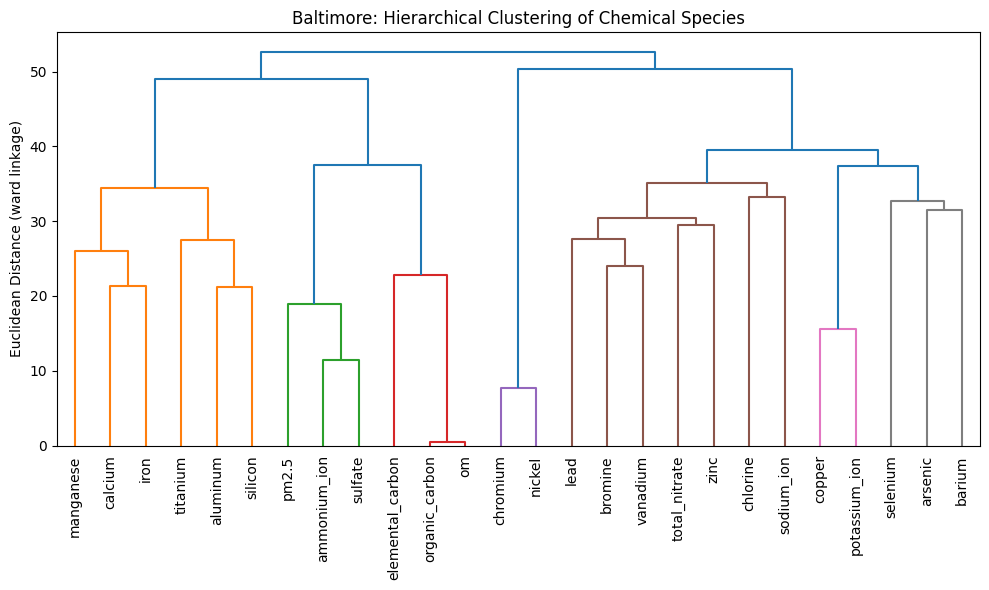

In [18]:
plot_variable_clustering(
    baltimore_con_log, 
    "Baltimore", 
    metric='euclidean', 
    linkage='ward'
)

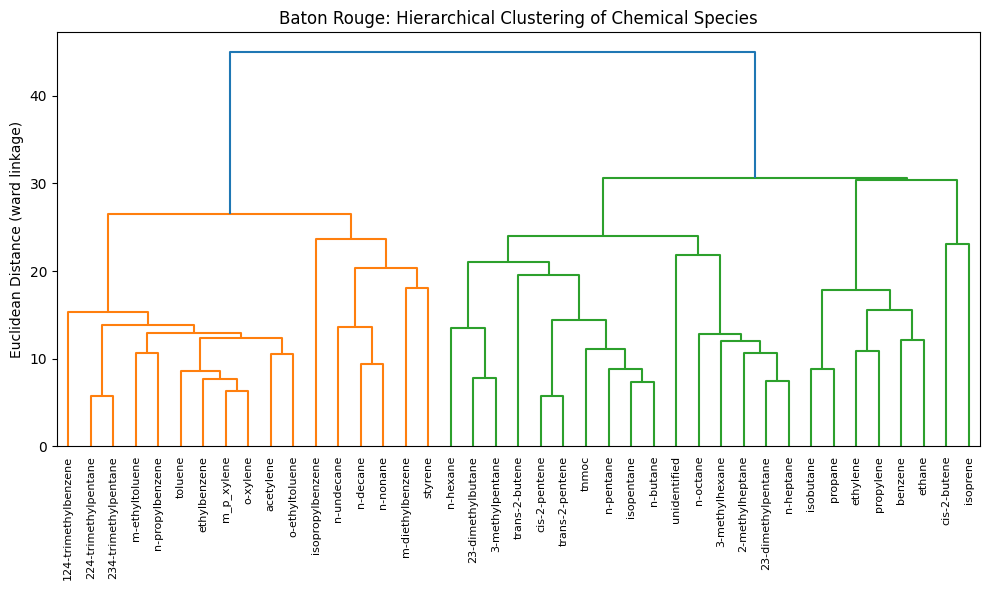

In [19]:
plot_variable_clustering(
    baton_rouge_con_log, 
    "Baton Rouge", 
    metric='euclidean', 
    linkage='ward'
)

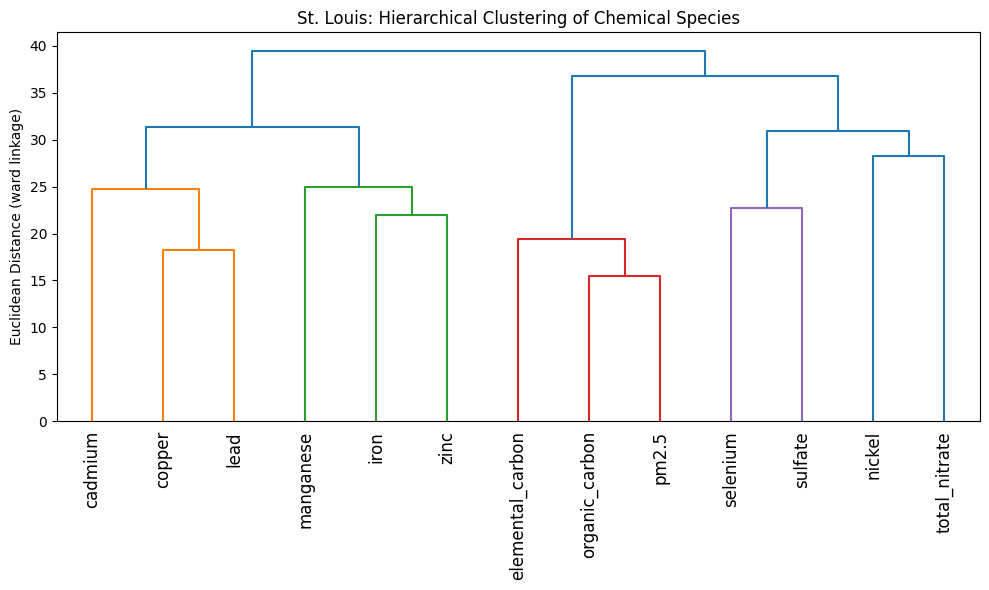

In [20]:
plot_variable_clustering(
    st_louis_con_log, 
    "St. Louis", 
    metric='euclidean', 
    linkage='ward'
)